In [1]:
## Python package imports 
import numpy as np
import matplotlib
import scipy.integrate as sint
import matplotlib.pyplot as plt

## respic imports
from rsrespic.fields import fields
from rsrespic.particles import particles
from rsrespic.solvers import solvers
from rsrespic.utilities import constants, diagnostics, utilities
import rsrespic.utilities as util

from respic_fodo import uniform_focusing_channel as uf_cell

## rsbeams imports
#from rsbeams.rsptcls import bunch


## constants 
q = constants.cgs_constants['q']
c = constants.cgs_constants['c']
c_mks = c / 100.
m_e = constants.cgs_constants['m_e']
m_p = constants.cgs_constants['m_p']
pi = np.pi

from scipy.constants import epsilon_0 as e0
from scipy.constants import m_e as m_e_mks
from scipy.constants import elementary_charge as q_mks

# Note that this example requires rsbeams

In [63]:
## Particle definitions 
emit = 1.0e-6
charge_per_cm_mks = 8.0e-11
charge_per_meter = charge_per_cm_mks * 100
Q = constants.charge_mks_to_cgs(charge_per_cm_mks)

n_particles = 5000
ds = 1.0
s = 0.0
E = 2.0e6


## This is where we initialize a KV distribuiton
newKVBunch = bunch.StandardBunch(n_particles, dist='KV', emitx = emit, emity = emit)
newKVBunch.set_longitudinal_coordinates(dpop=0.00) #here we reset the dpop value
newKVBunch.set_transverse_coordinates()

new_distribution = particles.distribution()
new_distribution.type = 'KV'
new_distribution.e_x = newKVBunch.emitx
new_distribution.e_y = newKVBunch.emity
new_distribution.N = newKVBunch.npart
new_distribution.x = newKVBunch.particles[:,0] * 100.
new_distribution.xp = newKVBunch.particles[:,1]
new_distribution.y = newKVBunch.particles[:,2] * 100.
new_distribution.yp = newKVBunch.particles[:,3]
new_distribution.z = newKVBunch.particles[:,4]
new_distribution.pz = newKVBunch.particles[:,5]

sigma_x = np.max(np.sqrt(new_distribution.x**2 + new_distribution.y**2))

## Particle distributions
my_kv_beam = particles.particles_2D_delta(new_distribution, # dx_tent = 1 * L_min, dy_tent = 1 * L_min, 
    bunch_charge = Q, species_charge = q, species_mass = m_e, K_e = E)

I0 = 4. * np.pi * e0 * (my_kv_beam.m_0 / 1000) * c_mks ** 3. /  q_mks
I = my_kv_beam.beta * c_mks * charge_per_meter

K_s = I / I0 * 2. / (my_kv_beam.beta ** 3. * my_kv_beam.gamma ** 3.) / (sigma_x ** 2.)
K_e = 3.0 * emit ** 3 / sigma_x ** 4.  * 2.e11
K = K_s + K_e

print K_s * 10000.
print K_e * 10000.
print K_s/K_e


## Define the fields 
L_0 = 10. * sigma_x ## Half the domain size
L_min = L_0 / 20. ## minimum wavelength to resolve

#my_fields = fields.cartesian_2D(L_x = L_0, L_y = L_0,
#    L_x_min = L_min, L_y_min = L_min)

## This is where we instantiate the solver
#field_solver = solvers.field_solver_2D()
#my_fields.register_solver(field_solver)


## Define the fields using sin transform
k = 20
N_s = 1 * k
L_s = N_s * sigma_x
n_x = 10 * k
n_y = 10 * k

my_fields = fields.sin_transform_2D(L_x = L_s, L_y = L_s, 
                        n_modes_x = n_x, n_modes_y = n_y)

## This is where we instantiate the solver
field_solver = solvers.sine_transform_2D()
my_fields.register_solver(field_solver)



## instantiate the diagnostics 
ptcl_diag = diagnostics.bunch_statistics()
dumper = diagnostics.particle_dumper(file_name='ufc_20200117.h5')


0.30932107598409825
0.9378040955920812
0.3298354927622798


In [64]:
## Load the maps and define the stepper
maps = solvers.symplectic_maps()

step = uf_cell(s0 = 0, k = K * 10000., L = ds )



In [ ]:
## Here we run the simulation, 1000 steps using the stepper functions defined in the previous block
ptcl_diag.update(s, my_kv_beam)
dumper.dump(my_kv_beam, s)

k = 0

while k < 10000:

    s = step.one_turn_map(maps, my_fields, my_kv_beam, ptcl_diag, s, dumper = dumper)
    dumper.dump(my_kv_beam, s)

    if k%100 == 0:
        print k
        
    #ptcl_diag.update(s, my_kv_beam)
        
    k = k + 1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700


In [44]:
## Compute analytic expansion for benchmarkiung. 

current = my_kv_beam.beta * c_mks * charge_per_meter

s_array = ptcl_diag.get_parameter('s') / 100.

r_analyitic = utilities.round_beam_expansion(s_array, 2. * newKVBunch.emit, sigma_x/100.,
        current, my_kv_beam.gamma, my_kv_beam.m_0)

r_zero_current = utilities.round_beam_expansion(s_array, 2. * newKVBunch.emit, sigma_x/100.,
        0.0, my_kv_beam.gamma, my_kv_beam.m_0)


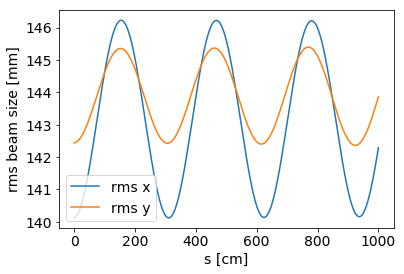

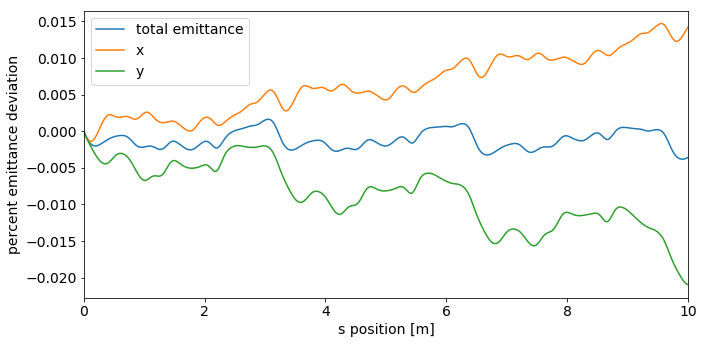

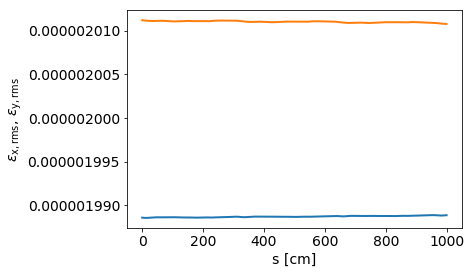

In [47]:
## Plotting 
plt.rcParams.update({'font.size': 14})

x_key = 's'
y_key = 'rms_x'
xrms = ptcl_diag.get_parameter('rms_x') * 1000
yrms = ptcl_diag.get_parameter('rms_y') * 1000
s = ptcl_diag.get_parameter('s')

plt.figure()
plt.plot(s, xrms)
plt.plot(s, yrms)

#plt.ylim([0, 1.5])
plt.xlabel('s [cm]')
plt.ylabel('rms beam size [mm]')
plt.legend(['rms x', 'rms y'])
plt.savefig('respic_benchmark_kv.pdf')

ex = ptcl_diag.get_parameter('ex_rms')
ey = ptcl_diag.get_parameter('ey_rms')
e_tot = np.sqrt(ex ** 2. + ey ** 2.)
s = ptcl_diag.get_parameter('s')


plt.figure(figsize=(10,5))
plt.plot(s / 100., (e_tot - e_tot[0]) / e_tot[0] * 100., label = 'total emittance')
plt.plot(s / 100., (ex - ex[0]) / ex[0] * 100., label = 'x')
plt.plot(s / 100., (ey - ey[0]) / ey[0] * 100., label = 'y')
plt.ylabel('percent emittance deviation')
plt.xlabel('s position [m]')
plt.legend()
plt.xlim([0,10])
plt.tight_layout()
plt.savefig('emittance.pdf')

plt.figure()
ptcl_diag.plot('s', 'ex_rms')
ptcl_diag.plot('s', 'ey_rms')

plt.xlabel('s [cm]')
plt.ylabel(r'$\epsilon_\mathrm{x, rms}$, $\epsilon_\mathrm{y, rms}$')
plt.show()



In [53]:
num_dens = charge_per_meter / 1.602e-19 / (np.pi * (2.9e-3 ** 2.))

In [62]:
f_p = np.sqrt(num_dens * (1.602e-19) ** 2. / (m_e_mks * e0)) / (2.0 * np.pi)
l_sim = 100 * 10 * ds
t_sim = l_sim / (my_kv_beam.beta * c)
print t_sim
print my_kv_beam.beta 
print t_sim/(1/f_p), f_p

10.0
3.4069340538013e-08
0.9790741174634026
9.40271595276585 275987612.4480523


299.792458


In [16]:
print I0

17045.0874776


In [48]:
dumper.close()

0.16492736551190829